In [1]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker
from torch_points3d.datasets.segmentation import IGNORE_LABEL
from torch_points3d.metrics.scannet_segmentation_tracker import ScannetSegmentationTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq

from collections import defaultdict

from PIL import Image

import matplotlib.pyplot as plt 

%matplotlib inline

CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

import os
import os.path as osp
import copy
import torch
import hydra
import logging
import scipy.ndimage
import numpy as np
from PIL import Image
import open3d as o3d

# Import building function for model and dataset
from torch_points3d.datasets.dataset_factory import instantiate_dataset
from torch_points3d.models.model_factory import instantiate_model

# Import BaseModel / BaseDataset for type checking
from torch_points3d.models.base_model import BaseModel
from torch_points3d.datasets.base_dataset import BaseDataset

# Import from metrics
from torch_points3d.metrics.base_tracker import BaseTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq
from torch_points3d.metrics.model_checkpoint import ModelCheckpoint

# Utils import
from torch_points3d.utils.colors import COLORS
from torch_points3d.utils.wandb_utils import Wandb
from torch_points3d.utils.config import getattr_recursive
from torch_points3d.visualization import Visualizer
from torch_points3d.core.data_transform.transforms import PointcloudMerge
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS


log = logging.getLogger(__name__)

def get_seen_points(mm_data):
    ### Select seen points
    csr_idx = mm_data.modalities['image'][0].view_csr_indexing
    dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
    # take subset of only seen points without re-indexing the same point
    mm_data = mm_data[dense_idx_list.unique()]
    return mm_data

def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

def get_random_view_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    selected_view_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        selected_idx = torch.randint(low=0, high=m2feats_of_seen_point.shape[0], size=(1,))
        selected_pred = m2feats_of_seen_point[selected_idx].squeeze(0)
        selected_view_preds.append(selected_pred)
    selected_view_preds = torch.stack(selected_view_preds, dim=0)
        
    return selected_view_preds




[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/scratch-shared/fsun/dvata'

# dataset_config = 'segmentation/multimodal/Feng/scannet-val-val.yaml'   

dataset_config = 'segmentation/multimodal/Feng/scannet-superconvergence-adamw.yaml'   
# models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
# model_name = 'MVFusion_3D_small_6views'                       # specific model
# model_name = 'Res16UNet13-15'                       # specific model



# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f.yaml'   
models_config = 'segmentation/multimodal/Feng/small_3d.yaml' 
model_name = 'MVFusion_small_6views_Res16UNet13-12'

checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2023-03-16/07-29-17'

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks
cfg.data.m2f_preds_dirname = 'pspnet18_no_flow'
cfg.data.n_views = cfg.models[model_name].backbone.transformer.n_views
print("n_views: ", cfg.data.n_views)

# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)|
print(f"Time = {time() - start:0.1f} sec.")

n_views:  6
Load predicted 2D semantic segmentation labels from directory  pspnet18_no_flow
initialize train dataset
initialize val dataset
Time = 15.6 sec.


In [5]:
# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)
print(model)

# Load the checkpoint and recover the 'best_miou' model weights
checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)

# Prepare the model for training
model = model.cuda()
print('Model loaded')


Creating model: MVFusion_small_6views_Res16UNet13-12
task:  segmentation.multimodal
tested_model_name:  MVFusion_small_6views_Res16UNet13-12
class_name:  MVFusionAPIModel
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d
name, cls of chosen model_cls:  MVFusionAPIModel <class 'torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d.MVFusionAPIModel'>
x feature dim:  {'FEAT': 1}
nc_in:  65
nc_in:  32
nc_in:  32
nc_in:  64
nc_in:  128
Return attention maps!
Enabling checkpointing for:  c
nc_in:  256
nc_in:  128
nc_in:  128
nc_in:  64
MVFusionAPIModel(
  (backbone): MVFusionSparseConv3dUnet(
    (inner_modules): ModuleList(
      (0): Identity()
    )
    (down_modules): ModuleList(
      (0): MultimodalBlockDown(
        (block_1): Identity()
        (block_2): Identity()
        (image): MVFusionUnimodalBranch(
          drop_3d=None
          drop_mod=None
          keep_last_view=False
          checkpointing=c
          (transformerfusion): DVA_cls_

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# Scannet 2D validation score: evaluate roughly every 100th frame in each sequence

- slight error: we evaluate on 640x480, while official benchmark evaluates on 1280 x 920

In [6]:
# Set dataloaders
dataset.create_dataloaders(
    model,
    6,
    True,
    6,
    False,
    train_only=False,
    val_only=True,
    test_batch_size=1
)
tracker = dataset.get_tracker(False, False)
tracker.reset('val')


scans_dir = "/scratch-shared/fsun/data/scannet/scans"
GT_NAME = "label-filt-scannet20"
MASK_NAME = "m2f_masks"

val_scans = list(dataset.val_dataset.MAPPING_IDX_TO_SCAN_VAL_NAMES.values())


n_imgs_per_scan = []

for scan in val_scans:
    print("scan: ", scan)

    
    scan_p = osp.join(scans_dir, scan)
    mask_dir = osp.join(scan_p, MASK_NAME)
    gt_dir = osp.join(scan_p, GT_NAME)
    
    im_names = sorted(os.listdir(mask_dir), key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))
    im_idx = [int(x.split(".")[0]) for x in im_names]

    # Find images that are closest to the 100th frame
    max_idx = im_idx[-1]
    n_imgs_per_scan.append(max_idx // 100 + 1)
    for i in range(max_idx // 100 + 1):
        closest_idx = min(im_idx, key=lambda x:abs(x-i*100))
        
        pred_im = osp.join(mask_dir, f"{closest_idx}.png")
        gt_im = osp.join(gt_dir, f"{closest_idx}.png")
        
        pred_im = np.asarray(Image.open(pred_im))
        gt_im = np.asarray(Image.open(gt_im)).astype(float)  - 1 # label correction
                
        tracker.track(gt_labels=gt_im, pred_labels=pred_im, model=None)
        
        
print(tracker.get_metrics())

scan:  scene0011_00
scan:  scene0011_01
scan:  scene0015_00
scan:  scene0019_00
scan:  scene0019_01
scan:  scene0025_00
scan:  scene0025_01
scan:  scene0025_02
scan:  scene0030_00
scan:  scene0030_01
scan:  scene0030_02
scan:  scene0046_00
scan:  scene0046_01
scan:  scene0046_02
scan:  scene0050_00
scan:  scene0050_01
scan:  scene0050_02
scan:  scene0063_00
scan:  scene0064_00
scan:  scene0064_01
scan:  scene0077_00
scan:  scene0077_01
scan:  scene0081_00
scan:  scene0081_01
scan:  scene0081_02
scan:  scene0084_00
scan:  scene0084_01
scan:  scene0084_02
scan:  scene0086_00
scan:  scene0086_01
scan:  scene0086_02
scan:  scene0088_00
scan:  scene0088_01
scan:  scene0088_02
scan:  scene0088_03
scan:  scene0095_00
scan:  scene0095_01
scan:  scene0100_00
scan:  scene0100_01
scan:  scene0100_02
scan:  scene0131_00
scan:  scene0131_01
scan:  scene0131_02
scan:  scene0139_00
scan:  scene0144_00
scan:  scene0144_01
scan:  scene0146_00
scan:  scene0146_01
scan:  scene0146_02
scan:  scene0149_00


In [62]:
n_imgs_official = []
d = "/home/fsun/temp_dir/scans/tasks/scannet_frames_25k"

for s in val_scans:
    print(s)
    
    n_imgs_official.append(len(os.listdir(osp.join(d, s, 'label'))))
        

for i in range(len(n_imgs_per_scan)):
    if n_imgs_per_scan[i] != n_imgs_official[i]:
        print(i)
        print(n_imgs_per_scan[i], n_imgs_official[i])


scene0011_00
scene0011_01
scene0015_00
scene0019_00
scene0019_01
scene0025_00
scene0025_01
scene0025_02
scene0030_00
scene0030_01
scene0030_02
scene0046_00
scene0046_01
scene0046_02
scene0050_00
scene0050_01
scene0050_02
scene0063_00
scene0064_00
scene0064_01
scene0077_00
scene0077_01
scene0081_00
scene0081_01
scene0081_02
scene0084_00
scene0084_01
scene0084_02
scene0086_00
scene0086_01
scene0086_02
scene0088_00
scene0088_01
scene0088_02
scene0088_03
scene0095_00
scene0095_01
scene0100_00
scene0100_01
scene0100_02
scene0131_00
scene0131_01
scene0131_02
scene0139_00
scene0144_00
scene0144_01
scene0146_00
scene0146_01
scene0146_02
scene0149_00
scene0153_00
scene0153_01
scene0164_00
scene0164_01
scene0164_02
scene0164_03
scene0169_00
scene0169_01
scene0187_00
scene0187_01
scene0193_00
scene0193_01
scene0196_00
scene0203_00
scene0203_01
scene0203_02
scene0207_00
scene0207_01
scene0207_02
scene0208_00
scene0217_00
scene0221_00
scene0221_01
scene0222_00
scene0222_01
scene0231_00
scene0231_01

In [61]:
sum(n_imgs_per_scan), sum(n_imgs_official)

(5323, 5436)

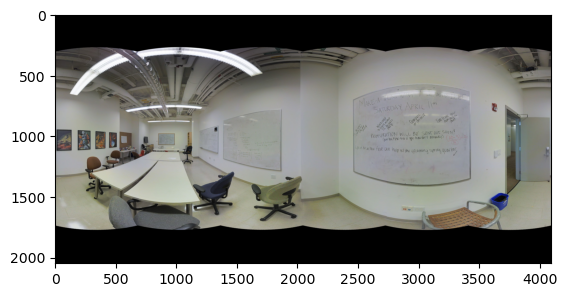

In [51]:
a = Image.open("/scratch-shared/fsun/dvata/s3disfused/image/area_5b/pano/rgb/camera_fbf9fb1e43e34ee3bbda6b7c5e5ca7a6_conferenceRoom_2_frame_equirectangular_domain_rgb.png")

# plt.imshow(np.array(CLASS_COLORS)[np.array(a)].astype(np.uint8))
plt.imshow(a)

In [113]:
def read_axis_align_matrix(filename):
    lines = open(filename).readlines()
    axis_align_matrix = None
    for line in lines:
        if "axisAlignment" in line:
            axis_align_matrix = torch.Tensor([float(x) for x in line.rstrip().strip("axisAlignment = ").split(" ")]).reshape((4, 4))
            break
    return axis_align_matrix

def get_semantic_image_from_camera(dataset, scene, mesh_triangles, intrinsic, extrinsic, class_id_faces, im_size=(480, 640)):
    """
    Returns the back-projected semantic label image given camera parameters and (semantic) mesh.
    """
    
    # Initialize rays for given camera
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
        intrinsic_matrix=intrinsic,
        extrinsic_matrix=extrinsic,
        width_px=im_size[1],
        height_px=im_size[0],
    )

    # Get result
    ans = scene.cast_rays(rays)

    primitive_ids = ans['primitive_ids'].numpy()
    primitive_uvs = ans['primitive_uvs'].numpy()

    # Select the closest vertex for each valid face in the projected mesh
    valid_mask = primitive_ids != scene.INVALID_ID

    # https://stackoverflow.com/questions/45212949/vertex-of-a-3d-triangle-that-is-closest-to-a-point-given-barycentric-parameter-o
    w_coords = (1 - primitive_uvs[:, :, 0][valid_mask] - primitive_uvs[:, :, 1][valid_mask])
    barycentric_coords = np.concatenate((w_coords[:, None], primitive_uvs[valid_mask]), axis=-1)

    selected_vertex_idx = np.argmax(barycentric_coords, axis=-1)

    contained_mesh_triangles = mesh_triangles[primitive_ids[valid_mask]]
    closest_mesh_vertices = contained_mesh_triangles[range(len(barycentric_coords)), selected_vertex_idx]
    
    # Map mesh vertices to semantic label
    labels = class_id_faces[closest_mesh_vertices]
    # Remap to [0 ; num_labels - 1]
    labels = dataset.val_dataset._remap_labels(torch.tensor(labels))

    # Visualize back-projection
    image = torch.ones(im_size, dtype=torch.long) * -1
    image[valid_mask] = labels


    # NN interpolation at invalid pixels          
    nearest_neighbor = scipy.ndimage.morphology.distance_transform_edt(
        image==-1, return_distances=False, return_indices=True)    

    image = image[nearest_neighbor].numpy()
    return image

def mesh_to_image(cfg, dataset, path_to_submission, scans_dir, output_dir, save_output='if_not_exists'):
    # User input
    output_image_size = (480, 640)
    preprocessed_2d_data_dir = "/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/processed/processed_2d_val"

    ########################################################################################################################
    input_mask_name = "ViT_masks"
    scan_names = list(dataset.val_dataset.MAPPING_IDX_TO_SCAN_VAL_NAMES.values())

    for scan_name in Ctq(scan_names):
        print(scan_name)
        # Output folder location
        refined_mask_dir = osp.join(output_dir, scan_name, f"{input_mask_name}_refined", f"MVFusion_3D_small_6views")

        if not osp.exists(refined_mask_dir):
            os.makedirs(refined_mask_dir)
            
        # Load data
        mesh = o3d.io.read_triangle_mesh(f"{scans_dir}/{scan_name}/{scan_name}_vh_clean_2.ply")
        mesh_triangles = np.asarray(mesh.triangles)
        mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)

        # Load predicted class label per vertex
        class_id_faces = np.loadtxt(f"{path_to_submission}/{scan_name}.txt").astype(int)

        # Camera parameters
        intrinsic = np.loadtxt(f"{scans_dir}/{scan_name}/sens/intrinsic/intrinsic_depth.txt")[:3, :3]
        
        
        im_names = [x.split(".")[0] for x in os.listdir(osp.join(output_dir, scan_name, 'pose'))]
        poses = torch.concat([torch.tensor(np.loadtxt(osp.join(output_dir, scan_name, 'pose', f+'.txt'))).unsqueeze(0) for 
                 f in im_names], dim=0).float()
                        

#         # Undo axis alignment for extrinsics  
#         axis_align_matrix_path = osp.join(scans_dir, scan_name, scan_name + '.txt')
#         axis_align_matrix = read_axis_align_matrix(axis_align_matrix_path)
#         inv = torch.linalg.inv(axis_align_matrix.T)
#         poses = inv.T @ poses       

        # Make world-to-camera
        extrinsics = torch.linalg.inv(poses).numpy()
#         extrinsics = poses.numpy()

        # Raycasting
        scene = o3d.t.geometry.RaycastingScene()
        scene.add_triangles(mesh)

        for i in range(len(im_names)):
            image = get_semantic_image_from_camera(dataset=dataset, scene=scene, mesh_triangles=mesh_triangles, intrinsic=intrinsic,
                                                   extrinsic=extrinsics[i], 
                                                   class_id_faces=class_id_faces, im_size=output_image_size)
        

            # Save refined prediction (backprojected from mesh + interpolated missing pixels)
            image = Image.fromarray(image.astype(np.uint8), 'L')
            im_save_path = osp.join(refined_mask_dir, im_names[i] + '.png')
            image.save(im_save_path)   
            
#             break
#         break

path_to_submission = '/home/fsun/DeepViewAgg/notebooks/thesis_results/submission_labels/MVFusion_3D_small_6views/ViT_masks'
scans_dir = "/scratch-shared/fsun/data/scannet/scans"
mesh_to_image(cfg, dataset, path_to_submission, scans_dir, "/home/fsun/temp_dir/scans/tasks/scannet_frames_25k", save_output='if_not_exists')

  0%|          | 0/312 [00:00<?, ?it/s]

scene0011_00
scene0011_01
scene0015_00
scene0019_00
scene0019_01
scene0025_00
scene0025_01
scene0025_02
scene0030_00
scene0030_01
scene0030_02
scene0046_00
scene0046_01
scene0046_02
scene0050_00
scene0050_01
scene0050_02
scene0063_00
scene0064_00
scene0064_01
scene0077_00
scene0077_01
scene0081_00
scene0081_01
scene0081_02
scene0084_00
scene0084_01
scene0084_02
scene0086_00
scene0086_01
scene0086_02
scene0088_00
scene0088_01
scene0088_02
scene0088_03
scene0095_00
scene0095_01
scene0100_00
scene0100_01
scene0100_02
scene0131_00
scene0131_01
scene0131_02
scene0139_00
scene0144_00
scene0144_01
scene0146_00
scene0146_01
scene0146_02
scene0149_00
scene0153_00
scene0153_01
scene0164_00
scene0164_01
scene0164_02
scene0164_03
scene0169_00
scene0169_01
scene0187_00
scene0187_01
scene0193_00
scene0193_01
scene0196_00
scene0203_00
scene0203_01
scene0203_02
scene0207_00
scene0207_01
scene0207_02
scene0208_00
scene0217_00
scene0221_00
scene0221_01
scene0222_00
scene0222_01
scene0231_00
scene0231_01

In [6]:

def _remap_labels(semantic_label):
    """Remaps labels to [0 ; num_labels -1]. Can be overriden."""
    VALID_CLASS_IDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 24, 28, 33, 34, 36, 39]
    NUM_CLASSES = 20
    
    new_labels = torch.tensor(semantic_label).clone()
    mapping_dict = {indice: idx for idx, indice in enumerate(VALID_CLASS_IDS)}
    for idx in range(NUM_CLASSES):
        if idx not in mapping_dict:
            mapping_dict[idx] = IGNORE_LABEL
#     for idx in self.donotcare_class_ids:
#         mapping_dict[idx] = IGNORE_LABEL
    for source, target in mapping_dict.items():
        mask = semantic_label == source
        new_labels[mask] = target

    broken_labels = new_labels >= len(VALID_CLASS_IDS)
    new_labels[broken_labels] = IGNORE_LABEL

    return new_labels.numpy()

# Set dataloaders
dataset.create_dataloaders(
    model,
    6,
    True,
    6,
    False,
    train_only=False,
    val_only=True,
    test_batch_size=1
)
tracker = dataset.get_tracker(False, False)
tracker.reset('val')
d = "/home/fsun/temp_dir/scans/tasks/scannet_frames_25k"


scan_names = list(dataset.val_dataset.MAPPING_IDX_TO_SCAN_VAL_NAMES.values())

for s in Ctq(scan_names):
    s_p = osp.join(d, s)
    gt_dir = osp.join(s_p, 'label')
    mask_dir = osp.join(s_p, 'ViT_masks')
    for im_name in os.listdir(gt_dir):
        gt_im = osp.join(gt_dir, im_name)
        mask_im = osp.join(mask_dir, im_name)
        
                
        mask_im = np.asarray(Image.open(mask_im).resize((1296, 968), 0))
        gt_im = np.asarray(Image.open(gt_im).resize((1296, 968), 0)).astype(float) # - 1 # label correction
        gt_im = _remap_labels(gt_im)
        
        print(gt_im.shape, mask_im.shape)

        tracker.track(gt_labels=gt_im, pred_labels=mask_im, model=None)

print(tracker.get_metrics())
print(tracker._miou_per_class)

  0%|          | 0/312 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/home/fsun/temp_dir/scans/tasks/scannet_frames_25k/scene0011_00/ViT_masks/001200.png'

In [16]:
scan_dir = "/home/fsun/temp_dir/scans/tasks/scannet_frames_25k"

scan_names = list(dataset.val_dataset.MAPPING_IDX_TO_SCAN_VAL_NAMES.values())

for s in Ctq(scan_names):
    scan_p = osp.join(scan_dir, s)
    
    color_dir = osp.join(scan_p, 'color')
    resized_dir = osp.join(scan_p, 'color_resized')
    os.makedirs(resized_dir, exist_ok=True)
    
    for im in os.listdir(color_dir):
        rgb = Image.open(osp.join(color_dir, im)).resize((640, 480), Image.BILINEAR)
        
        rgb.save(osp.join(resized_dir, im))
        

  0%|          | 0/312 [00:00<?, ?it/s]

In [20]:

for s in Ctq(scan_names):
    scan_p = osp.join(scan_dir, s)

    resized_dir = osp.join(scan_p, 'color_resized')
    
    destination_dir = "/home/fsun/data/scannet_images_val/images/validation"

    for im in os.listdir(color_dir):
        if im[-3:] == 'jpg':
            os.symlink(osp.join(resized_dir, im), osp.join(destination_dir, f"{s}-{im}"))
            
#         break
#     break

  0%|          | 0/312 [00:00<?, ?it/s]

### Select qualitative results
